# TODO

Need to decide which of the UKB results I am using. 
* In particular I need to think about the rare associations - as there seem to be too many of them... should i use a different threshold? That's why I have the 256 right?
* Make sure I don't have trait duplicates

Determine my actual lists of annotations to use in main analysis
* Biological
* Network
    * Are network features missing values filled with 0?
* Trait

Should I split by common-only, rare-only, shared for initial annotation plots? Won't be able to do the violin plots though



#  SetUp

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('/cellar/users/snwright/Git/Network_Evaluation_Tools/neteval/')

from scipy.stats import wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

In [2]:
datadir='/cellar/users/snwright/Data/RareCommon'
refdir='/cellar/users/snwright/Data/RareCommon/Reference/'
outdir='/cellar/users/snwright/Data/RareCommon/Annotations'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/Figure_Annotations'
featuredir='/cellar/users/snwright/Data/RareCommon/outputs/Features'

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size':7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

## Gene sets

In [39]:
def load_traitlist(traitfile):
    with open(traitfile, 'r') as f:
        traits = [x.strip() for x in f.readlines()]
    return traits

r_traitlist = load_traitlist(os.path.join(datadir, 'inputs', 'March_2025', 'rare.traitlist')) 
c_traitlist = load_traitlist(os.path.join(datadir, 'inputs', 'March_2025', 'common.traitlist')) 
ukb_r_traitlist_raw = load_traitlist(os.path.join(datadir, 'inputs', 'UKB', 'gb_ga_rare.traitlist')) 
ukb_c_traitlist_raw = load_traitlist(os.path.join(datadir, 'inputs', 'UKB', 'gb_ga_common.traitlist')) 

In [120]:
filtered_ukb = pd.read_csv('/cellar/users/snwright/Data/RareCommon/inputs/UKB/filtered_matched_traits.tsv', sep='\t', index_col=0)
filtered_ukb['StudyC_clean'] = filtered_ukb.StudyC.apply(lambda z: z.replace(': https://doi.org/10.1101/', '').replace('UK2', 'UKB2'))

In [121]:
ukb_r_traitlist = list(filtered_ukb.StudyR.values)
ukb_c_traitlist = list(filtered_ukb.StudyC_clean.values)

In [25]:
over_df = pd.read_csv(os.path.join(datadir,'outputs/overlap/March_2025', 'RV_GC_overlap.txt'))
over_df_ukb = pd.read_csv(os.path.join(datadir,'outputs/overlap/UKB', 'ukb_overlap.txt'))

## Biological Annotation Data

In [219]:
files = {
    'Cite':'Gene_Citation_Dec23.txt', 'MisSyn': 'Gene_MisSyn.txt', 
    'Disgen':'Gene_disgen.txt', 'pli': 'Gene_pLI.txt',
    'dgi': 'Gene_DGI_scores.txt', 'omim': 'Gene_OMIM.txt', 
    'Length': 'Gene_length.txt', 'Prot': 'Gene_prot.txt',
    'GO': 'Gene_GO.txt' , 'phylop': 'Gene_PhyloP.txt',
    'mrna':'Gene_mRNA.txt'
}

annot_dir = '/cellar/users/snwright/Data/RareCommon/Annotations'

In [220]:
# transforms need a pseudocount if there are zeros in the annotations

transform = {'Cite': lambda x: np.log10(x+1),
 'MisSyn': None,
 'Disgen': lambda x: np.log10(x+1),
 'pli': None,
 'dgi': lambda x: np.log10(x),
 'omim': lambda x: np.log10(x+1),
 'Length': lambda x: np.log10(x),
 'Prot': None,
 'GO': lambda x: np.log10(x+1),
 'phylop': None,
 'mrna': lambda x: np.log10(x+0.0001)}

metric = {'Cite': np.median,
 'MisSyn': np.mean,
 'Disgen': np.median,
 'pli': np.median,
 'dgi': np.mean,
 'omim': np.mean,
 'Length': np.median,
 'Prot': np.median,
 'GO': np.median,
 'phylop': np.median,
 'mrna': np.median}

missing_val = {'Cite':0,
 'MisSyn': None,
 'Disgen': 0,
 'pli': None,
 'dgi': None,
 'omim': 0,
 'Length': None,
 'Prot': None,
 'GO': 0,
 'phylop': None,
 'mrna': None}

usecols = {'Cite': 'CitationCount',
 'MisSyn': 'mis.z_score',
 'Disgen': 'n_DISGENET',
 'pli': 'LOEUF',
 'dgi': 'mean_score',
 'omim': 'OMIM_count',
 'Length': 'GeneSize',
 'Prot': 'Mean_prot',
 'GO': 'n_GO',
 'phylop': 'PhyloP_mean',
 'mrna': 'Mean_mRNA'}

labels = {'Cite': 'Citation Count',
 'MisSyn': 'Missense intolerance',
 'Disgen': 'Disease Assoc.',
 'pli': 'LOEUF',
 'dgi': 'Drug Interactions',
 'omim': 'Mendelian Assoc',
 'Length': 'Gene Size',
 'Prot': 'Protein Abun.',
 'GO': 'GO Terms',
 'phylop': 'Gene Conservation',
 'mrna': 'mRNA Exp.'}

In [221]:
bio_dfs = {}
for met, file in files.items():
    bio_dfs[met] = pd.read_csv(os.path.join(annot_dir, file), sep='\t', index_col=0).reset_index().drop_duplicates().set_index('Entrez')
    print(met, bio_dfs[met].shape)

Cite (162986, 1)
MisSyn (18201, 2)
Disgen (14624, 1)
pli (17954, 3)
dgi (11157, 3)
omim (5959, 1)
Length (25013, 4)
Prot (11131, 2)
GO (20739, 4)
phylop (19827, 3)
mrna (34812, 2)


In [189]:
bio_dfs['mrna']

,Mean_mRNA,n_Expressed
Entrez,,
4513.0,38876.080556,54
4514.0,37999.582963,54
4508.0,37320.014630,54
4538.0,36013.387037,54
4512.0,33648.460741,54
...,...,...
26338.0,0.000000,0
390144.0,0.000000,0
81153.0,0.000000,0


## Network Annotation Data

In [29]:
all_pairs = [r_traitlist[i]+'_'+c_traitlist[i] for i in range(len(r_traitlist))]
len(all_pairs)

262

In [30]:
net = []
for pair in tqdm(all_pairs):
    try:
        x = pd.read_csv(os.path.join(featuredir, 'March_2025', f'network_stats_pcnet2_0_rare.traitlist.{pair}'), sep='\t', low_memory=False)
        net.append(x)
    except FileNotFoundError:
        print(f'{pair} not found')
net_df = pd.concat(net)

100%|██████████| 262/262 [00:02<00:00, 103.74it/s]


In [40]:
ukb_pairs = [ukb_r_traitlist[i]+'_'+ukb_c_traitlist[i] for i in range(len(ukb_r_traitlist))]
ukb_pairs_raw = [ukb_r_traitlist_raw[i]+'_'+ukb_c_traitlist_raw[i] for i in range(len(ukb_r_traitlist_raw))]
len(ukb_pairs)

86

In [37]:
ukb_net = []
for pair in tqdm(ukb_pairs):
    try:
        x = pd.read_csv(os.path.join(featuredir, 'UKB', f'network_stats_pcnet2_0_gb_ga_rare.traitlist.{pair}'), sep='\t', low_memory=False)
        ukb_net.append(x)
    except FileNotFoundError:
        print(f'{pair} not found')
net_ukb = pd.concat(ukb_net)

100%|██████████| 86/86 [00:00<00:00, 158.60it/s]


### Modularities

In [41]:
mod_df = pd.read_csv(os.path.join(featuredir, 'March_2025', 'network_modularities_pcnet2_0_rare.traitlist'), sep='\t')
mod_df.index = all_pairs
mod_df.columns = ['common', 'rare', 'overlap', 'subnetwork?', 'rare_common']
mod_df = mod_df.melt(value_name='Modularity', var_name='varset', ignore_index=False).reset_index(names='trait')
mod_ukb = pd.read_csv(os.path.join(featuredir, 'UKB', 'network_modularities_pcnet2_0_gb_ga_rare.traitlist'), sep='\t')
mod_ukb.index = ukb_pairs_raw
mod_ukb.columns = ['common', 'rare', 'overlap', 'subnetwork?', 'rare_common']
mod_ukb = mod_ukb.melt(value_name='Modularity', var_name='varset', ignore_index=False).reset_index(names='trait')

In [43]:
mod_ukb = mod_ukb[mod_ukb.trait.isin(ukb_pairs)]

In [44]:
net_df = net_df.merge(mod_df, on=['trait', 'varset'])
net_ukb = net_ukb.merge(mod_ukb, on=['trait', 'varset'])

## Trait Annotation Data

### UKB

In [122]:
# gwas atlas
ga_info = pd.read_csv(os.path.join(datadir, 'GWASAtlas', 'UKB_Atlas_Genebass_matched_traits.tsv'), sep='\t')
ga_info['StudyC'] = ga_info.StudyC.apply(lambda z: z.replace(': https://doi.org/10.1101/', ''))

In [123]:
ga_info = ga_info[ga_info.StudyC.isin(ukb_c_traitlist)]
ga_features = ga_info.drop(columns=['PMID', 'uniqTrait','ChapterLevel', 'SubchapterLevel', 'phecode', 'Note', 'Genome', 'SNPh2_se', 
                                    'SNPh2_z', 'SNPh2_l_se'])
ga_features['trait_type'] = ga_features.Ncase.apply(lambda z: 'categorical' if z>0 else 'continuous')
ga_features['case_control'] = ga_features.apply(lambda x: x.Ncase/x.N if x.trait_type=='categorical' else np.nan, axis=1)

In [125]:
# genebass

gb_info = pd.read_csv(os.path.join(datadir, 'GeneBASS', 'UKB_Atlas_matched_trait_info.txt'), sep='\t', index_col=0)
gb_info = gb_info[gb_info.StudyR.isin(ukb_r_traitlist)]
gb_features = gb_info.drop(columns=['inv_normalized', 'saige_version', 'phenocode','coding', 'modifier',
                                   'n_cases_defined', 'n_cases_both_sexes', 'n_cases_females', 'n_cases_males',
                                   'description', 'description_more', 'coding_description', 'category', 'pheno_sex'])
gb_features['case_control'] = gb_features.apply(lambda x: x.n_cases/x.N if x.trait_type=='categorical' else np.nan, axis=1)

### GCat

In [126]:
## gwas catalog
cat_info = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwascat_ravar_study_info.txt'), sep='\t')
cat_info['Year'] = cat_info['DATE ADDED TO CATALOG'].apply(lambda x: int(x.split('-')[0]))
cat_info.columns

Index(['DISEASE/TRAIT', 'ASSOCIATION COUNT', 'STUDY ACCESSION', 'COHORT',
       'MAPPED BACKGROUND TRAIT URI', 'SUMMARY STATS LOCATION', 'TRAIT_CODE',
       'DATE ADDED TO CATALOG', 'INITIAL SAMPLE SIZE', 'MAPPED_TRAIT',
       'PUBMED ID', 'N', 'MAPPED_GENE', 'TraitExp', 'MappedTraitExp', 'Cosine',
       'StudyTrait', 'Year'],
      dtype='object')

In [127]:
cat_info.COHORT.value_counts()

COHORT
BBJ|UKB|FinnGen                                                      25
Multiple                                                             14
UKB                                                                  13
BBJ|UKB                                                              10
NR                                                                    7
                                                                     ..
deCODE|EPIC_CAD|GerMIFS|HUNT|MGBB|CARDIoGRAMplusC4D|other|UKB|BBJ     1
Other                                                                 1
BioVU|deCODE|GERA|MD|Penn|UKB|Umea|NR                                 1
UKB|MVP                                                               1
HAPPIEST                                                              1
Name: count, Length: 81, dtype: int64

In [128]:
# not other columns from original study info for now. But do need ancestry info.
ancestries=pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'ancestries.v1.0.3.1_Jan29_2025.txt'), sep='\t', low_memory=False)
ancestries = ancestries[ancestries['STUDY ACCESSION'].isin(cat_info['STUDY ACCESSION'].values)]

In [129]:
ancestry_map = {'European': 'EUR', 'Aboriginal Australian':'Other', 'East Asian':'EAS', 'South Asian':'SAS',
       'Hispanic or Latin American':'AMX', 'African American or Afro-Caribbean':'AFR',
       'African American or Afro-Caribbean, African unspecified, European, East Asian, Hispanic or Latin American, South Asian':'MIXED',
       'NR':'Other', 'European, NR':'EUR', 'European, East Asian, NR':'EUR, EAS', 'NR, Other':'Other',
       'African unspecified':'AFR', 'Asian unspecified':'EAS',
       'Native American, Hispanic or Latin American':'AMX',
       'African unspecified, NR':'AFR', 'South East Asian':'SAS',
       'African American or Afro-Caribbean, African unspecified':'AFR',
       'Other admixed ancestry':'Other', 'Central Asian, South Asian':'SAS',
       'Greater Middle Eastern (Middle Eastern, North African or Persian)':'ARAB',
       'Sub-Saharan African':'AFR',
       'European, South Asian, East Asian, African unspecified, Hispanic or Latin American':'MIXED',
       'European, Other, Asian unspecified, Greater Middle Eastern (Middle Eastern, North African or Persian)': 'MIXED',
       'Asian unspecified, Oceanian':'Other',
       'African American or Afro-Caribbean, Sub-Saharan African, African unspecified':'AFR'}

In [130]:
ancestries['ANCESTRY'] = ancestries['BROAD ANCESTRAL CATEGORY'].map(ancestry_map)

In [131]:
cat_info = cat_info.merge(ancestries.loc[:, ('STUDY ACCESSION', 'ANCESTRY', 'INITIAL SAMPLE DESCRIPTION')], 
               left_on=['STUDY ACCESSION', 'INITIAL SAMPLE SIZE'], how='left',
                right_on=['STUDY ACCESSION', 'INITIAL SAMPLE DESCRIPTION']).drop(columns=['INITIAL SAMPLE DESCRIPTION'])

In [132]:
cat_info['SumStats'] = cat_info['SUMMARY STATS LOCATION'].apply(lambda x: 1 if isinstance(x, str) else 0)
cat_info.columns

Index(['DISEASE/TRAIT', 'ASSOCIATION COUNT', 'STUDY ACCESSION', 'COHORT',
       'MAPPED BACKGROUND TRAIT URI', 'SUMMARY STATS LOCATION', 'TRAIT_CODE',
       'DATE ADDED TO CATALOG', 'INITIAL SAMPLE SIZE', 'MAPPED_TRAIT',
       'PUBMED ID', 'N', 'MAPPED_GENE', 'TraitExp', 'MappedTraitExp', 'Cosine',
       'StudyTrait', 'Year', 'ANCESTRY', 'SumStats'],
      dtype='object')

In [133]:
gc_features = cat_info.drop(columns=['COHORT', 'MAPPED BACKGROUND TRAIT URI', 'SUMMARY STATS LOCATION', 'DATE ADDED TO CATALOG', 
                            'INITIAL SAMPLE SIZE', 'TraitExp', 'MappedTraitExp'])

In [134]:
## ravar
gene_count_info = pd.read_csv(os.path.join(datadir, 'RAVAR', 'ravar_gwascat_study_info.txt'), sep='\t')
rav_info = pd.read_csv(os.path.join(datadir, 'rv_study_info_cleaned_with_manual.tsv'), sep='\t', index_col=0)
rav_info = rav_info.drop(columns=['Notes'])

In [135]:
rav_info = rav_info.merge(gene_count_info.loc[:, ('rv_idx', 'Cosine', 'GeneCount')], on='rv_idx')

In [136]:
rv_features = rav_info.drop(columns=[ 'Trait Ontology id'])

# Data exploration

## Biological

In [137]:
## Correlation of all features

In [222]:
# Check for duplicate entries
for k, df in bio_dfs.items():
    df = df.reset_index().drop_duplicates(subset=['Entrez', usecols[k]]).set_index('Entrez')
    if len(df) != df.index.nunique():
        print(k, len(df), df.index.nunique())
# remaining duplicates we take the highest annotation value

MisSyn 18201 18093
dgi 11072 11064


In [223]:
bio_mat = {}
for k, df in bio_dfs.items():
    x = df.drop(columns=[z for z in df.columns if z != usecols[k]]).reset_index()
    # keep highest score
    x = x.sort_values(by=usecols[k],ascending=False).drop_duplicates(subset='Entrez').set_index('Entrez')
    if missing_val[k] is not None:
        x = x.fillna(missing_val[k])
    if transform[k] is not None:
        x = x[usecols[k]].apply(lambda z: transform[k](z))
    else:
        x = x.loc[:, usecols[k]]
    bio_mat[k] = x
bio_mat = pd.DataFrame({k: df for k, df in bio_mat.items()})    

In [224]:
bio_mat_raw = {}
for k, df in bio_dfs.items():
    x = df.drop(columns=[z for z in df.columns if z != usecols[k]]).reset_index()
    # keep highest score
    x = x.sort_values(by=usecols[k],ascending=False).drop_duplicates(subset='Entrez').set_index('Entrez')
    if missing_val[k] is not None:
        x = x.fillna(missing_val[k])
    if transform[k] is not None:
        x = x[usecols[k]].apply(lambda z: z)
    else:
        x = x.loc[:, usecols[k]]
    bio_mat_raw[k] = x
bio_mat_raw = pd.DataFrame({k: df for k, df in bio_mat_raw.items()})   

In [225]:
# remove any genes with only fewer than 3 annotation values
annot_counts = (~bio_mat.isnull()).sum(axis=1)
bio_mat = bio_mat.loc[annot_counts[annot_counts>2].index]

In [226]:
plot_mat = bio_mat.rename(columns={k: labels[k] for k in bio_mat.columns})

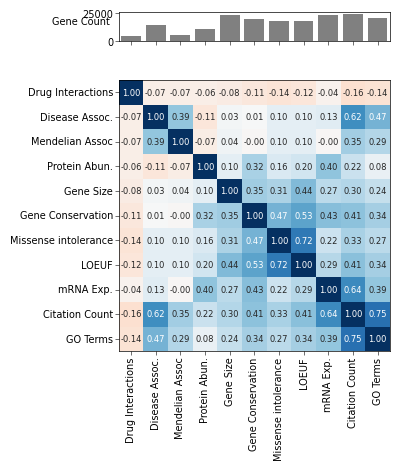

In [227]:
_,  [ax1, ax2] = plt.subplots(nrows=2, ncols=1,  sharex=False, figsize=(3.5,4.5), 
                                            gridspec_kw={'height_ratios':[1, 10]})
cg = sns.clustermap(plot_mat.corr(numeric_only=True, method='spearman'), figsize=(4,4), cmap='RdBu', center=0)
plt.close()
order= cg.dendrogram_row.reordered_ind
sns.heatmap(plot_mat.corr(numeric_only=True, method='spearman').iloc[order, order], cmap='RdBu', center=0, 
            square=True, annot=True, fmt='.2f', 
            annot_kws={'fontsize':6}, cbar_kws={'fraction': 0.5}, ax=ax2, cbar=False)
for spine in ax2.spines.values():
    spine.set_visible(True)      # Ensure the spine is visible         # Set the thickness of the border
    spine.set_edgecolor('black') 


label_order = plot_mat.corr(numeric_only=True, method='spearman').iloc[order, order].columns

sns.barplot(pd.DataFrame({'Genes':(~plot_mat.isnull()).sum()}).reset_index(), y='Genes', x='index', ax=ax1, 
            order=label_order, color='grey')
ax1.set_xticklabels([])
ax1.set_xlabel('')
ax1.set_ylabel('Gene Count', rotation=0)
plt.savefig(os.path.join(figdir, 'FeatureCorrelationsHeatmap_bio.svg'), bbox_inches='tight')

In [198]:
cg = sns.clustermap(plot_mat.corr(numeric_only=True, method='spearman'), figsize=(4,4), cmap='RdBu', center=0)
plt.close()
order= cg.dendrogram_row.reordered_ind
sns.heatmap(plot_mat.corr(numeric_only=True, method='spearman').iloc[order, order], cmap='RdBu', center=0, 
            square=True, annot=True, fmt='.2f',
            annot_kws={'fontsize':6}, cbar_kws={'shrink': 0.5}, cbar=True)
plt.savefig(os.path.join(figdir, 'FeatureCorrelationsHeatmap_bio_LEGEND.svg'), bbox_inches='tight')
plt.close()

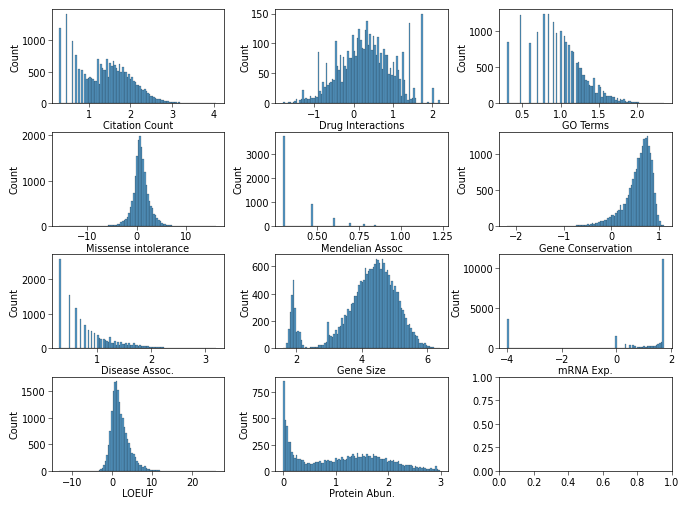

In [199]:
_, axs = plt.subplots(nrows=4, ncols=3, figsize=(8,6), gridspec_kw={'hspace':0.3, 'wspace':0.3})

for n, col in enumerate(plot_mat.columns):
    i = n//4 #row
    j = n%4 #col
    sns.histplot(plot_mat[col], bins=100, ax=axs[j,i])
    

## Network 

In [146]:
# this has to be across all gene sets tested as most of these are not defined for single genes? Some are but I don't think
# ... I need to be that nuanced for a supplemental figure. 

In [200]:
net_plot_labels = {'subnetwork_density': 'SubNet Density', 'n_components':'SubNet Components',
       'average_degree':'Avg. Degree', 'subnetwork_average_degree':'SubNet Avg. Degree', 'clustering': 'Avg. Clustering',
       'subnetwork_clustering': 'SubNet Avg. Clustering', 'assortativity':'Assortativity', 'average_path':'Avg. Shortest Path',
       'subnetwork_assortativity':'SubNet Assortativity', 'Modularity':'Modularity'}

In [201]:
net_df['Set'] = 'All'
net_ukb['Set'] = 'UKB'
plot_net = pd.concat([net_df, net_ukb]).reset_index(drop=True).rename(columns=net_plot_labels)
plot_net = plot_net.drop(columns='SubNet Assortativity')

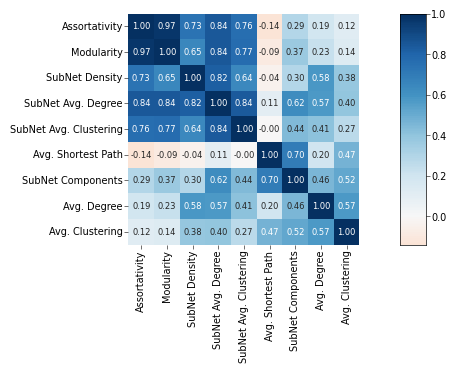

In [202]:
_,  [ax1, ax2] = plt.subplots(nrows=1, ncols=2,  sharex=False, figsize=(4,3), 
                                            gridspec_kw={'width_ratios':[10, 1]})
cg = sns.clustermap(plot_net.corr(numeric_only=True, method='spearman'), figsize=(4,4), cmap='RdBu', center=0)
plt.close()
order= cg.dendrogram_row.reordered_ind
sns.heatmap(plot_net.corr(numeric_only=True, method='spearman').iloc[order, order], cmap='RdBu', center=0, 
            square=True, annot=True, fmt='.2f', 
            annot_kws={'fontsize':6}, ax=ax1, cbar_ax=ax2, cbar_kws={'shrink':0.5})
for ax in [ax1, ax2]:    
    for spine in ax2.spines.values():
        spine.set_visible(True)      # Ensure the spine is visible         # Set the thickness of the border
        spine.set_edgecolor('black') 

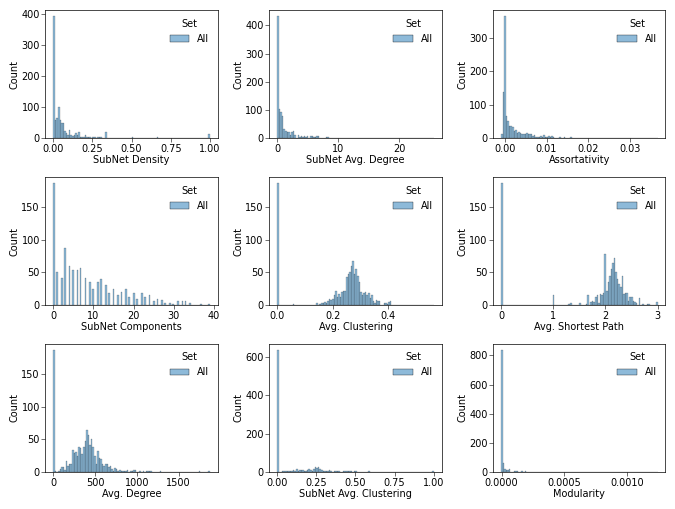

In [150]:
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,6), gridspec_kw={'hspace':0.3, 'wspace':0.3})

for n, col in enumerate(plot_net.columns[2:-1]):
    i = n//3 #row
    j = n%3 #col
    sns.histplot(plot_net.loc[:, (col, 'Set')],x=col, bins=100, ax=axs[j,i], hue='Set')

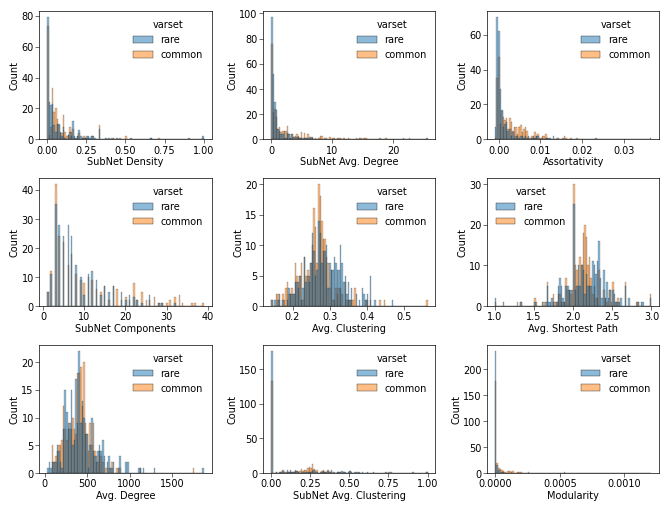

In [151]:
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,6), gridspec_kw={'hspace':0.3, 'wspace':0.3})

for n, col in enumerate(plot_net.columns[2:-1]):
    i = n//3 #row
    j = n%3 #col
    sns.histplot(plot_net[plot_net.varset.isin(['rare', 'common']) & (plot_net.Set=='All')].loc[:, (col, 'varset')],x=col, bins=100, ax=axs[j,i], hue='varset')

## Trait

### GWAS Atlas

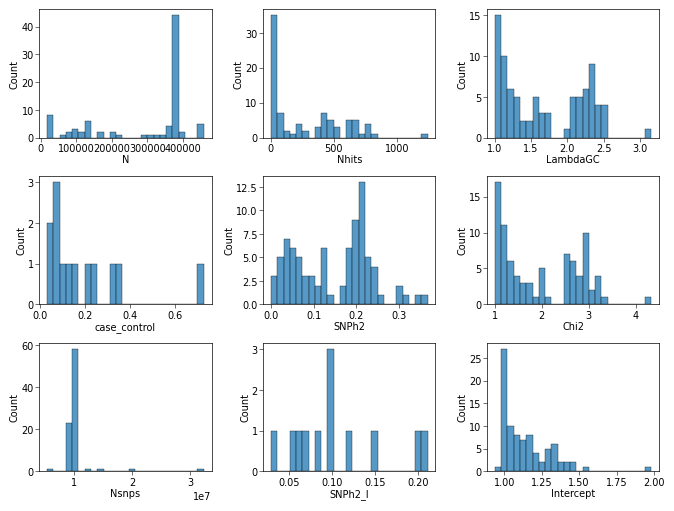

In [152]:
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,6), gridspec_kw={'hspace':0.3, 'wspace':0.3})

for n, col in enumerate([ 'N', 'case_control', 'Nsnps', 'Nhits', 'SNPh2', 'SNPh2_l', 'LambdaGC', 'Chi2', 'Intercept']):
    i = n//3 #row
    j = n%3 #col
    sns.histplot(ga_features[col], bins=25, ax=axs[j,i])

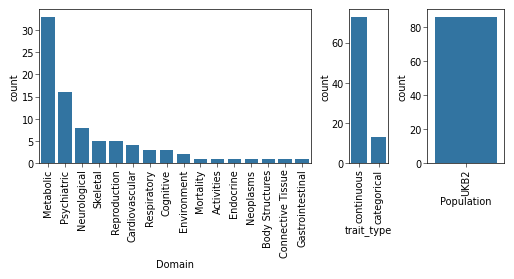

In [153]:
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 2), gridspec_kw={'width_ratios':[7, 1,2], 'wspace':0.3})
for i, feat in enumerate(['Domain', 'trait_type', 'Population']):
    sns.barplot(ga_features[feat].value_counts(), ax=axs[i])
    axs[i].tick_params(axis='x', rotation=90)

### Genebass

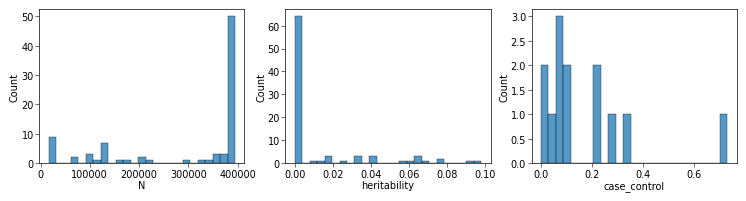

In [154]:
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 2))
for i, feat in enumerate(['N', 'heritability', 'case_control']):
    sns.histplot(gb_features, x=feat, ax=axs[i], bins=25)

<Axes: xlabel='trait_type'>

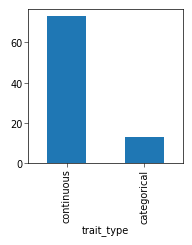

In [155]:
_ = plt.figure(figsize=(2,2))
gb_features.trait_type.value_counts().plot(kind='bar')

### GWAS Catalog

In [156]:
gc_features.columns

Index(['DISEASE/TRAIT', 'ASSOCIATION COUNT', 'STUDY ACCESSION', 'TRAIT_CODE',
       'MAPPED_TRAIT', 'PUBMED ID', 'N', 'MAPPED_GENE', 'Cosine', 'StudyTrait',
       'Year', 'ANCESTRY', 'SumStats'],
      dtype='object')

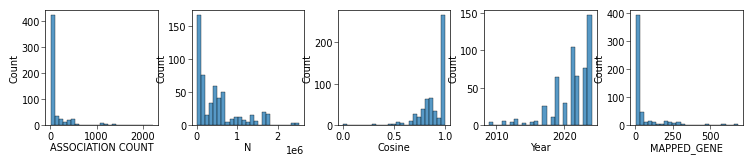

In [157]:
_, axs = plt.subplots(nrows=1, ncols=5, figsize=(9,1.5), gridspec_kw={'hspace':0.3, 'wspace':0.3})

for n, col in enumerate([ 'ASSOCIATION COUNT', 'N', 'Cosine', 'Year', 'MAPPED_GENE']):
    #i = n//2 #row
    #j = n%2 #col
    sns.histplot(gc_features[col], bins=25, ax=axs[n])

<Axes: xlabel='ANCESTRY'>

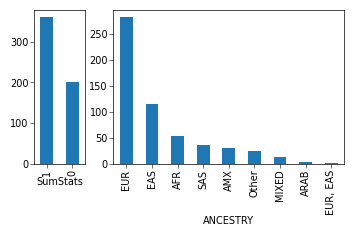

In [158]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(4,2), gridspec_kw={'width_ratios': [2, 9]})
gc_features.SumStats.value_counts().plot(kind='bar', ax=axs[0])
gc_features.ANCESTRY.value_counts().plot(kind='bar', ax=axs[1])

### RAVAR

In [89]:
# what do I do about the fact that the vast majority of rare studies here also are UKB? What is even the point?
# I have to guess that it is because of my N prioritization - should I also try to prioritize non-UKB first? Though I'd bet
# I'll still end up with a lot of UKB studies. 
# "Standardized UKB set" and "Expanded set
# Need to be clear about the language here. But also probably worth getting more non-UKB RAVAR traits....

In [159]:
rv_features.columns
rv_features.PMID.nunique()

27

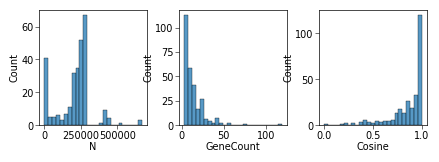

In [160]:
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(5,1.5), gridspec_kw={'hspace':0.3, 'wspace':0.3})

for n, col in enumerate(['N', 'GeneCount', 'Cosine']):
    #i = n//2 #row
    #j = n%2 #col
    sns.histplot(rv_features[col], bins=25, ax=axs[n])

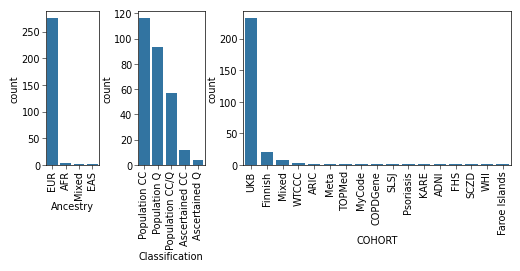

In [161]:
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 2), gridspec_kw={'width_ratios':[4,5, 20], 'wspace':0.3})
for i, feat in enumerate(['Ancestry', 'Classification', 'COHORT']):
    sns.barplot(rv_features[feat].value_counts(), ax=axs[i])
    axs[i].tick_params(axis='x', rotation=90)

## Combined

# Functions

## Analysis

In [162]:
from scipy.stats import wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection


def pair_test_annotations(rtraits, ctraits, features, input_dir='Jan_2025', metric_map=None):
    all_results = []
    for i, rt in tqdm(enumerate(rtraits)):
        ct = ctraits[i]
        rgenes = pd.read_csv(os.path.join(datadir,'inputs', input_dir, f'{rt}_RV.txt'), sep='\t').Entrez.unique()
        cgenes = pd.read_csv(os.path.join(datadir,'inputs', input_dir,f'{ct}_CV.txt'), sep='\t').Entrez.unique()
        df = get_summary_values(rgenes, cgenes, features, metric_map=metric)
        df['TraitC'] = ct
        df['TraitR'] = rt
        df = df.sort_values(by='p')
        n_p = len(df.dropna(subset='p'))
        qvals = fdrcorrection(df.dropna(subset='p').p[0:n_p], 0.05)[1]
        df['q'] = list(qvals) + [np.nan] * (len(df)-n_p)
        all_results.append(df)
    return pd.concat(all_results)
    
    
def get_summary_values(rgenes, cgenes, all_features, metric_map=None):
    all_genes = list(set(rgenes).union(set(cgenes)))
    test_df = all_features.loc[[g for g in all_genes if g in all_features.index.values]]
    rg = [g for g in rgenes if g in test_df.index.values]
    cg= [g for g in cgenes if g in test_df.index.values]
    
    df_r = test_df.loc[rg]
    df_c = test_df.loc[cg]
    p = {}
 
    
    for met in df_r.columns:
        
        if (len(df_r.dropna(subset=met)) > 2) and (len(df_c.dropna(subset=met)) > 2):
            p[met] = mannwhitneyu(df_r.dropna(subset=met)[met].values,df_c.dropna(subset=met)[met].values).pvalue
        else:
            p[met] = np.nan
    if metric_map is None:
        median_cols = test_df.columns
    else:
        mean_cols = [x for x in test_df.columns if metric_map[x] == np.mean]
        median_cols = [x for x in test_df.columns if x not in mean_cols]
    mean_r = df_r.mean().loc[mean_cols].to_dict()
    median_r = df_r.median().loc[median_cols].to_dict()
    mean_c = df_c.mean().loc[mean_cols].to_dict()
    median_c = df_c.median().loc[median_cols].to_dict()
    return pd.DataFrame({'R':{**mean_r, **median_r}, 'C': {**mean_c, **median_c},
                        'p': p}).reset_index(names=['metric'])


def global_paired_test(df, c_col='C', r_col='R'):
    results = {}
    for metric in df.metric.unique():
        results[metric] = wilcoxon(df[df.metric==metric][c_col].values, df[df.metric==metric][r_col].values, nan_policy='omit').pvalue
    out_df = pd.DataFrame({'p': results})
    out_df['q'] = fdrcorrection(out_df.p.values, alpha=0.05)[1]
    out_df['C_mean'] = df.groupby('metric')[c_col].mean()
    out_df['R_mean'] = df.groupby('metric')[r_col].mean()
    out_df['C_med'] = df.groupby('metric')[c_col].median()
    out_df['R_med'] = df.groupby('metric')[r_col].median()
    out_df['Text'] = out_df.q.apply(lambda z: '***' if z < 1e-8 else "**" if z<1e-5 else '*' if z<1e-2 else 'n.s.') 
    return out_df

## Plotting

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cbook as cbook
import pandas as pd


def plot_annotation_boxplots(df, labels=None, groups=None, palette=['mediumseagreen', 'skyblue'],
                            annot_dict=None, plot_sets=['R', 'C']):
    if labels is not None:
        df['label'] = df.metric.map(labels)
        if annot_dict is not None:
            for k in df['metric'].unique():
                annot_dict[labels[k]] = annot_dict[k]
    else:
        df['label'] = df.metric
    if groups is not None:
        n_plots = len(groups)
        widths = [len(g) for g in groups]
        if groups[0][0] not in df['label'].values:
            new_groups = [[labels[x] for x in g] for g in groups]
            groups = new_groups
    else:
        n_plots = df.label.nunique()
        groups = [[g] for g in df.label.unique()]
        widths = [1 for i in range(n_plots)]

    
    _, axs = plt.subplots(nrows=1, ncols=n_plots, figsize=(7,2), gridspec_kw={'width_ratios':widths, 'wspace':0.5})
    for ax, plot_vals in zip(axs, groups):
        try:
            sns.boxplot(df[df['label'].isin(plot_vals)].loc[:, ['label']+plot_sets].melt(id_vars=['label']), 
                        x='label', y='value', hue='variable', fliersize=0, ax=ax, legend=False, 
                        palette=palette,hue_order=plot_sets, linewidth=0.3, order=plot_vals, saturation=1)
            ymin, ymax = get_plot_limits(df[df['label'].isin(plot_vals)].loc[:, ['label']+plot_sets].melt(id_vars=['label']))
        except:
            sns.boxplot(df[df['label'].isin(plot_vals)].loc[:, ['label']+plot_sets].melt(id_vars=['label']), 
                        x='label', y='value', hue='varset', fliersize=0, ax=ax, legend=False, 
                        palette=palette,hue_order=plot_sets, linewidth=0.3, order=plot_vals, saturation=1)
            ymin, ymax = get_plot_limits(df[df['label'].isin(plot_vals)].loc[:, ['label']+plot_sets].melt(id_vars=['label']), var_col='varset')
        margin = np.abs((ymax-ymin) * 0.05)
        ax.set_ylim(ymin - margin, ymax+margin)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=90)
        if annot_dict is not None:
            for i, val in enumerate(plot_vals):
                ax.text(x=i, y=(ymax+margin)*0.95, s=annot_dict[val], horizontalalignment='center')
            
    axs[0].set_ylabel('Annotation Value')


def get_plot_limits(df, label_col='label', var_col='variable'):
    whisker_low = []
    whisker_high = []
    for (cat, var), group in df.groupby([label_col, var_col]):
        # Remove missing values
        vals = group['value'].dropna().values
        if len(vals) == 0:
            continue
        # Compute the boxplot stats using matplotlib's utility.
        stats = cbook.boxplot_stats(vals, whis=1.5)
        if stats:
            whisker_low.append(stats[0]['whislo'])
            whisker_high.append(stats[0]['whishi'])
    # If we got any stats, set the limits with a little margin.
    if whisker_low and whisker_high:
        y_min = min(whisker_low)
        y_max = max(whisker_high)
        # Add 5% margin to top and bottom
        margin = 0.05 * (y_max - y_min)
    return y_min, y_max





def plot_annotation_violins(df, labels=None, order=None, rcolor='#008751', ccolor='#0061a1'):
    _ = plt.figure(figsize=(2, 3))
    if 'logq' not in df.columns:
        df['logq'] = df['q'].apply(lambda x: -1 * np.log10(x))
    df = df.assign(minus_logq = df['logq'] * -1)
    if labels is not None:
        plot_df = df.assign(Metric=df['metric'].map(labels))
    else:
        plot_df = df.assign(Metric=df['metric'].values)
    if order is None:
        order=list(plot_df[plot_df.C > plot_df.R].Metric.value_counts().index.values)
    try:
        sns.violinplot(plot_df[plot_df.C > plot_df.R], y='Metric', x='logq', color=ccolor, cut=0, inner=None, 
                       density_norm='count', orient='h', linewidth=0.3, order=order, saturation=1)
        sns.violinplot(plot_df[plot_df.C < plot_df.R], y='Metric', x='minus_logq', color=rcolor, cut=0, inner=None, 
                       density_norm='count', orient='h', linewidth=0.3, order=order, saturation=1)
    except:
        return plot_df
    plt.vlines(x=0, ymin=10.5, ymax=-0.5, color='black', linewidth=0.5)
    plt.vlines(x=[np.log10(0.05), -1 * np.log10(0.05)], ymin=-0.5, ymax=10.5, linewidth=0.5, linestyle='--', color='black')
    plt.ylim(-0.5, 10.5)
    plt.gca().invert_yaxis()
    _ = plt.xticks([-5, -1.3, 0, 1.3, 5, 10], ['10-5','' , 1,'', '10-5', '10-10'])
    return order

# UKB

## Collect Data

## Biological

In [228]:
plot_labels={'omim':'OMIM', 'dgi':'Drug Score', 'mrna': 'mRNA Exp', 'Cite':'Citations', 'pli':'LOEUF',
       'Length':'Gene Size', 'phylop':'PhyloP', 'Prot': 'Prot Exp', 'GO':'GO', 'Disgen':'Disgen', 
            'MisSyn': 'MisSyn'}

In [229]:
uk_res_df = pair_test_annotations(ukb_r_traitlist, ukb_c_traitlist, bio_mat, input_dir='UKB')

86it [00:06, 12.43it/s]


In [230]:
uk_res_df_raw = pair_test_annotations(ukb_r_traitlist, ukb_c_traitlist, bio_mat_raw, input_dir='UKB')

86it [00:12,  7.08it/s]


In [231]:
uk_p_df = global_paired_test(uk_res_df_raw)
uk_p_df['Text'] = uk_p_df.q.apply(lambda z: '***' if z < 1e-8 else "**" if z<1e-5 else '*' if z<1e-2 else 'n.s.') 

In [232]:
def plot_annotation_vplots(df, labels=None, groups=None, palette=['mediumseagreen', 'skyblue'],
                            annot_dict=None, plot_sets=['R', 'C'], log_plots=[]):
    if labels is not None:
        df['label'] = df.metric.map(labels)
        if annot_dict is not None:
            for k in df['metric'].unique():
                annot_dict[labels[k]] = annot_dict[k]
    else:
        df['label'] = df.metric
    if groups is not None:
        n_plots = len(groups)
        widths = [len(g) for g in groups]
        if groups[0][0] not in df['label'].values:
            new_groups = [[labels[x] for x in g] for g in groups]
            groups = new_groups
    else:
        n_plots = df.label.nunique()
        groups = [[g] for g in df.label.unique()]
        widths = [1 for i in range(n_plots)]

    
    _, axs = plt.subplots(nrows=1, ncols=n_plots, figsize=(7,2), gridspec_kw={'width_ratios':widths, 'wspace':0.5})
    for ax, plot_vals in zip(axs, groups):
        try:
            sns.violinplot(df[df['label'].isin(plot_vals)].loc[:, ['label']+plot_sets].melt(id_vars=['label']), 
                        x='label', y='value', hue='variable', cut=0, ax=ax, legend=False, split=True,gap=.1, inner="quart",
                        palette=palette,hue_order=plot_sets, linewidth=0.3, order=plot_vals, saturation=1,
                          inner_kws={'linewidth':0.75}, log_scale=(plot_vals[0] in log_plots))
            ymin, ymax = get_plot_limits(df[df['label'].isin(plot_vals)].loc[:, ['label']+plot_sets].melt(id_vars=['label']))
        except:
            try:
                sns.violinplot(df[df['label'].isin(plot_vals)].loc[:, ['label']+plot_sets].melt(id_vars=['label']), 
                            x='label', y='value', hue='varset', cut=0, ax=ax, legend=False, gap = .1, 
                            palette=palette,hue_order=plot_sets, linewidth=0.3, order=plot_vals, saturation=1,
                              inner_kws={'linewidth':0.75}, log_scale=(plot_vals[0] in log_plots))
                ymin, ymax = get_plot_limits(df[df['label'].isin(plot_vals)].loc[:, ['label']+plot_sets].melt(id_vars=['label']), var_col='varset')
            except:
                return df[df['label'].isin(plot_vals)].loc[:, ['label']+plot_sets].melt(id_vars=['label'])
        margin = np.abs((ymax-ymin) * 0.05)
        #ax.set_ylim(ymin - margin, ymax+margin)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=90)
        if annot_dict is not None:
            for i, val in enumerate(plot_vals):
                ax.text(x=i, y=(ymax+margin)*0.95, s=annot_dict[val], horizontalalignment='center')
            
    axs[0].set_ylabel('Annotation Value')
    return axs

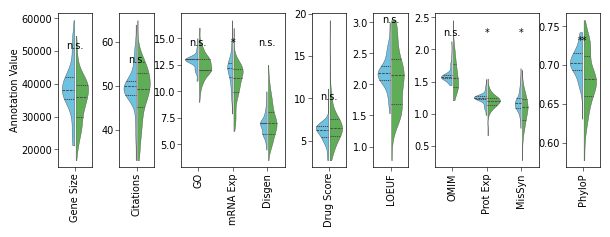

In [287]:
axs = plot_annotation_vplots(uk_res_df_raw,labels=plot_labels,  groups= [['Length'], ['Cite'], ['GO', 'mrna', 'Disgen'], ['dgi'], 
                                          ['pli'],['omim', 'Prot', 'MisSyn'], ['phylop']],
                        annot_dict=uk_p_df.Text.to_dict(), palette=['#6ec1e0','#5fad56'], plot_sets=['C', 'R'])
plt.savefig(os.path.join(figdir, 'bio_annotation_boxplots_ukb.svg'), bbox_inches='tight')

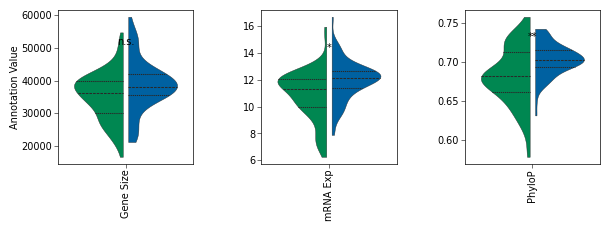

In [234]:
axs = plot_annotation_vplots(uk_res_df_raw,labels=plot_labels,  groups= [['Length'], ['mrna'], 
                                           ['phylop']],
                        annot_dict=uk_p_df.Text.to_dict(), palette=['#008751', '#0061a1'])

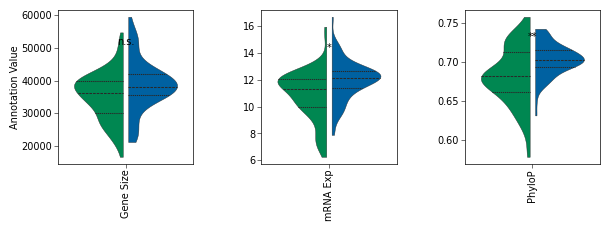

In [186]:
axs = plot_annotation_vplots(uk_res_df_raw,labels=plot_labels,  groups= [['Length'], ['mrna'], 
                                           ['phylop']],
                        annot_dict=uk_p_df.Text.to_dict(), palette=['#008751', '#0061a1'])

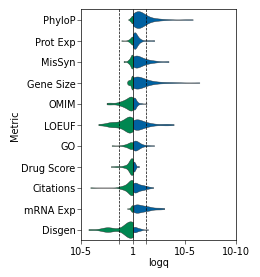

In [210]:
viol_order = plot_annotation_violins(uk_res_df_raw, labels=plot_labels)

## Network 

In [171]:
test_net_ukb = net_ukb.drop(columns='subnetwork_assortativity').melt(id_vars=['Set', 'trait', 'varset'], var_name='metric').pivot(index=['metric', 'Set', 'trait'],columns='varset', values='value').reset_index()
test_net_ukb.index.name=None

In [172]:
p_net_ukb = global_paired_test(test_net_ukb, c_col='common', r_col='rare')

KeyError: 'Column not found: common'

In [173]:
axs = plot_annotation_vplots(test_net_ukb, plot_sets=['rare', 'common'], groups = [['average_degree'], 
                         ['n_components', 'subnetwork_average_degree'], ['average_path'],
                        ['clustering', 'subnetwork_clustering'], ['subnetwork_density'], ['assortativity'],
                        ['Modularity']], annot_dict=p_net_ukb.Text.to_dict(),palette=['#008751', '#0061a1'],
                            log_plots=['Modularity'])
axs[6].set_yscale('log')
#plot_annotation_boxplots(test_net_ukb,labels=plot_labels,  groups= [['Length'], ['Cite'], ['GO', 'mrna', 'Disgen'], ['dgi','pli'], 
#                                          ['omim', 'Prot', 'MisSyn'], ['phylop']], 
#                        annot_dict=p_df.Text.to_dict(), palette=['#008751', '#0061a1'])

NameError: name 'p_net_ukb' is not defined

In [ ]:
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,6), gridspec_kw={'hspace':0.3, 'wspace':0.3})

for n, col in enumerate(plot_net.columns[2:-1]):
    i = n//3 #row
    j = n%3 #col
    sns.histplot(plot_net[plot_net.varset.isin(['rare', 'common']) & (plot_net.Set=='UKB')].loc[:, (col, 'varset')],x=col, bins=100, ax=axs[j,i], hue='varset')

## Trait

## Combined

# GWAS Cat

## Collect Data

## Biological

In [280]:
plot_labels={'omim':'OMIM', 'dgi':'Drug Score', 'mrna': 'mRNA Exp', 'Cite':'Citations', 'pli':'LOEUF',
       'Length':'Gene Size', 'phylop':'PhyloP', 'Prot': 'Prot Exp', 'GO':'GO', 'Disgen':'Disgen', 
            'MisSyn': 'MisSyn'}

In [241]:
res_df = pair_test_annotations(r_traitlist, c_traitlist, bio_mat, input_dir='March_2025')

262it [00:19, 13.64it/s]


In [242]:
res_df_raw = pair_test_annotations(r_traitlist, c_traitlist, bio_mat_raw, input_dir='March_2025')

262it [00:20, 12.99it/s]


In [243]:
p_df = global_paired_test(res_df_raw)
p_df['Text'] = p_df.q.apply(lambda z: '***' if z < 1e-8 else "**" if z<1e-5 else '*' if z<1e-2 else 'n.s.') 

In [244]:
res_df_raw

,metric,R,C,p,TraitC,TraitR,q
9,phylop,0.710526,0.461530,0.095238,GCST90250893_HP_0000093,34375979_HP_0000093,0.761905
10,mrna,12.099135,40.945663,0.261905,GCST90250893_HP_0000093,34375979_HP_0000093,0.876190
4,Disgen,5.000000,17.000000,0.400000,GCST90250893_HP_0000093,34375979_HP_0000093,0.876190
3,Cite,41.500000,56.000000,0.547619,GCST90250893_HP_0000093,34375979_HP_0000093,0.876190
6,Length,78041.500000,122207.000000,0.547619,GCST90250893_HP_0000093,34375979_HP_0000093,0.876190
...,...,...,...,...,...,...,...
9,phylop,0.529032,0.693028,0.244118,GCST90104907_EFO_0010822,34375979_EFO_0010822,0.278992
10,mrna,8.719376,21.138241,0.676471,GCST90104907_EFO_0010822,34375979_EFO_0010822,0.676471
1,dgi,18.683809,0.827900,NaN,GCST90104907_EFO_0010822,34375979_EFO_0010822,NaN
2,omim,1.400000,2.000000,NaN,GCST90104907_EFO_0010822,34375979_EFO_0010822,NaN


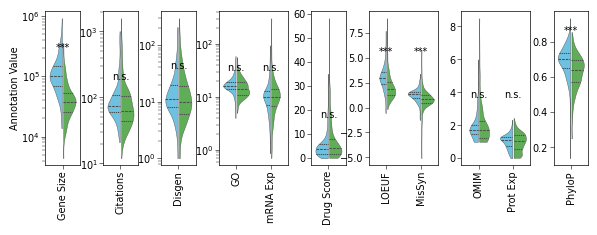

In [283]:
plot_annotation_vplots(res_df_raw,labels=plot_labels,  groups= [['Length'], ['Cite'],['Disgen'], ['GO', 'mrna'], ['dgi'], 
                                          ['pli', 'MisSyn'], ['omim', 'Prot'], ['phylop']], 
                        annot_dict=p_df.Text.to_dict(), palette=['#6ec1e0','#5fad56'],plot_sets=['C', 'R'],
                      log_plots = ['Gene Size', 'Citations', 'Disgen', 'GO'])
plt.savefig(os.path.join(figdir, 'bio_annotation_boxplots_expanded.svg'), bbox_inches='tight')

array([<Axes: ylabel='Annotation Value'>, <Axes: >, <Axes: >],
      dtype=object)

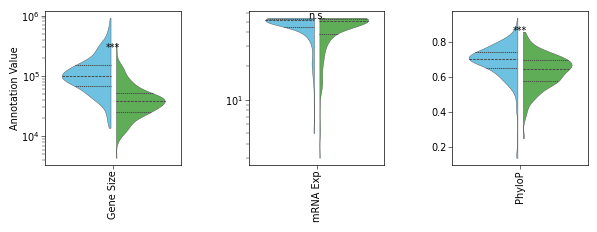

In [239]:
plot_annotation_vplots(res_df_raw,labels=plot_labels,  groups= [['Length'],['mrna'], ['phylop']], 
                        annot_dict=p_df.Text.to_dict(), palette=['#6ec1e0', '#5fad56'], plot_sets=['C', 'R'],
                      log_plots = ['Gene Size', 'mRNA Exp'])

/tmp/ipykernel_2327187/3638459344.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['logq'] = df['q'].apply(lambda x: -1 * np.log10(x))


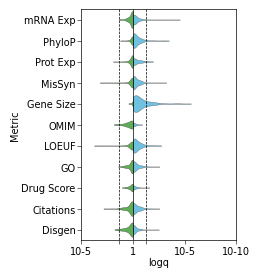

In [180]:
_ = plot_annotation_violins(res_df_raw.dropna(), labels=plot_labels, rcolor='#5fad56', ccolor='#6ec1e0', order=viol_order)

## Network 

In [181]:
test_net = net_df.drop(columns='subnetwork_assortativity').melt(id_vars=['Set', 'trait', 'varset'], var_name='metric').pivot(index=['metric', 'Set', 'trait'],columns='varset', values='value').reset_index()
test_net.index.name=None

In [182]:
p_net = global_paired_test(test_net, c_col='common', r_col='rare')

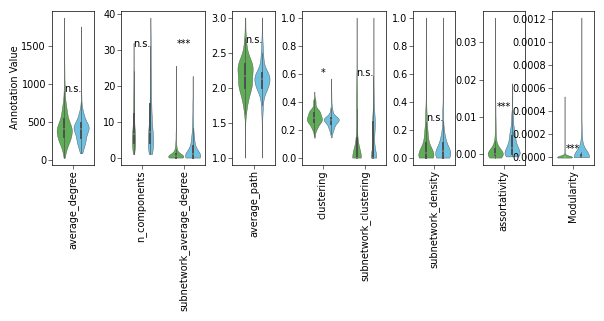

In [183]:
x = plot_annotation_vplots(test_net, plot_sets=['rare', 'common'], groups = [['average_degree'], 
                         ['n_components', 'subnetwork_average_degree'], ['average_path'],
                        ['clustering', 'subnetwork_clustering'], ['subnetwork_density'], ['assortativity'],
                        ['Modularity']], annot_dict=p_net.Text.to_dict(),palette=['#5fad56', '#6ec1e0'])
#plot_annotation_boxplots(test_net_ukb,labels=plot_labels,  groups= [['Length'], ['Cite'], ['GO', 'mrna', 'Disgen'], ['dgi','pli'], 
#                                          ['omim', 'Prot', 'MisSyn'], ['phylop']], 
#                        annot_dict=p_df.Text.to_dict(), palette=['#008751', '#0061a1'])

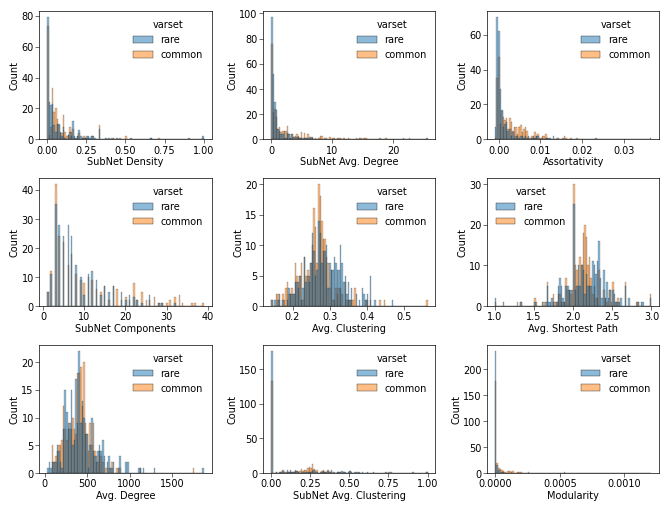

In [184]:
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,6), gridspec_kw={'hspace':0.3, 'wspace':0.3})

for n, col in enumerate(plot_net.columns[2:-1]):
    i = n//3 #row
    j = n%3 #col
    sns.histplot(plot_net[plot_net.varset.isin(['rare', 'common'])].loc[:, (col, 'varset')],x=col, bins=100, ax=axs[j,i], hue='varset')

## Trait

## Combined

## Output figures

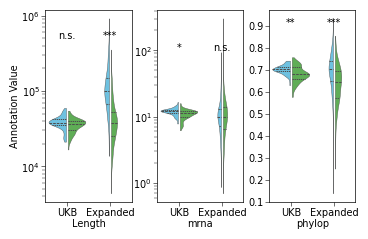

In [288]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume your two DataFrames are uk_res_df_raw and res_df_raw.
# Add a column to identify the dataset.
uk_res_df_raw['dataset'] = 'UKB'
res_df_raw['dataset'] = 'Expanded'

# Combine the DataFrames.
combined_df = pd.concat([uk_res_df_raw, res_df_raw], ignore_index=True)
plot_labels=None
# (Optional) Map metric names to labels if needed.
if plot_labels is not None:
    combined_df['label'] = combined_df.metric.map(plot_labels)
else:
    combined_df['label'] = combined_df.metric

# Define the groups you want to plot.
groups = [['Length'], ['mrna'], ['phylop']]
logs = [True, True, False]
# Create a figure with one subplot per group.
fig, axs = plt.subplots(nrows=1, ncols=len(groups), figsize=(4, 2.5), gridspec_kw={'wspace': 0.3})

# For each group, subset the data and melt so that the measurement columns (e.g., 'C' and 'R') are in a single column.
annot_loc={'Length':5e5, 'mrna':100, 'phylop':0.9}
for ax, group, log in zip(axs, groups, logs):
    # Filter data for the current group.
    group_data = combined_df[combined_df['label'].isin(group)]
    
    # Melt the DataFrame so that the measurements become a single column.
    # Here, 'C' and 'R' are the columns you want to split by.
    melted = group_data.melt(id_vars=['label', 'dataset'], value_vars=['C', 'R'],
                             var_name='variable', value_name='value')
    
    # Create a violin plot using 'dataset' as the hue.
    sns.violinplot(x='dataset', y='value', hue='variable', data=melted, saturation=1,cut=0, legend=False, split=True,gap=.1, inner="quart",
                       hue_order=['C', 'R'], linewidth=0.3, width=0.9,
                          inner_kws={'linewidth':0.75},
               ax=ax, palette=['#6ec1e0', '#5fad56'], log_scale=log)
    
    #ax.set_title(group[0])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x')
    
    for i, val in enumerate(group):
        ax.text(x=0, y=annot_loc[val], s=uk_p_df.Text.to_dict()[val], horizontalalignment='center')
        ax.text(x=1, y=annot_loc[val], s=p_df.Text.to_dict()[val], horizontalalignment='center')
    
# Adjust the legend so it only appears once.
handles, labels = axs[0].get_legend_handles_labels()

axs[0].set_ylabel('Annotation Value')
for i, ax in enumerate(axs):
    ax.set_xlabel(groups[i][0])

#plt.tight_layout()
plt.savefig(os.path.join(figdir, 'key_biological_features_violins.svg'), bbox_inches='tight')


In [253]:
melted

,label,dataset,variable,value
0,phylop,UKB,C,0.689136
1,phylop,UKB,C,0.699181
2,phylop,UKB,C,0.738497
3,phylop,UKB,C,0.718531
4,phylop,UKB,C,0.705162
...,...,...,...,...
691,phylop,All,R,0.512381
692,phylop,All,R,0.675048
693,phylop,All,R,0.654878
694,phylop,All,R,0.720998


In [249]:
uk_res_df_raw

,metric,R,C,p,TraitC,TraitR,q,label,dataset
0,MisSyn,0.722558,1.045772,0.008596,GA_idx4174_UKB2_30048462,GB_UKB_idx3758_phebone_mineral_density_custom,0.094553,MisSyn,UKB
9,phylop,0.677525,0.689136,0.068138,GA_idx4174_UKB2_30048462,GB_UKB_idx3758_phebone_mineral_density_custom,0.374760,PhyloP,UKB
5,pli,1.773100,1.985500,0.197507,GA_idx4174_UKB2_30048462,GB_UKB_idx3758_phebone_mineral_density_custom,0.547155,LOEUF,UKB
10,mrna,11.864834,12.321265,0.229554,GA_idx4174_UKB2_30048462,GB_UKB_idx3758_phebone_mineral_density_custom,0.547155,mRNA Exp,UKB
7,Prot,1.261994,1.304762,0.248707,GA_idx4174_UKB2_30048462,GB_UKB_idx3758_phebone_mineral_density_custom,0.547155,Prot Exp,UKB
...,...,...,...,...,...,...,...,...,...
5,pli,2.085650,2.167050,0.438580,GA_idx4700_UKB2_BioRxiv288609,GB_UKB_idx3106_phe25394,0.636176,LOEUF,UKB
0,MisSyn,1.056436,1.246879,0.462673,GA_idx4700_UKB2_BioRxiv288609,GB_UKB_idx3106_phe25394,0.636176,MisSyn,UKB
9,phylop,0.686927,0.679532,0.535030,GA_idx4700_UKB2_BioRxiv288609,GB_UKB_idx3106_phe25394,0.653926,PhyloP,UKB
1,dgi,10.734678,7.144041,0.683359,GA_idx4700_UKB2_BioRxiv288609,GB_UKB_idx3106_phe25394,0.751695,Drug Score,UKB


In [248]:
for group in groups:
    group_data = combined_df[combined_df['label'].isin(group)]
    print(f"Group {group} data:")
    print(group_data.head())

Group ['Length'] data:
Empty DataFrame
Columns: [metric, R, C, p, TraitC, TraitR, q, label, dataset]
Index: []
Group ['mrna'] data:
Empty DataFrame
Columns: [metric, R, C, p, TraitC, TraitR, q, label, dataset]
Index: []
Group ['phylop'] data:
Empty DataFrame
Columns: [metric, R, C, p, TraitC, TraitR, q, label, dataset]
Index: []
